In [1]:
import gwgpr

In [2]:
import os
from astropy.io import ascii
import numpy.ma as ma
import numpy as np
import math
from astropy.table import Table, vstack
from cStringIO import StringIO
import base64
from IPython.display import display, HTML
import pandas as pd
# Turn off the max column width so the HTML 
# image tags don't get truncated 
pd.set_option('display.max_colwidth', -1)

# Turning off the max column will display all the data in
# our arrays so limit the number of element to display
pd.set_option('display.max_seq_items', 2)

In [3]:
# Load all of the NR data

main_dir = '/home/daniel/data/gravitational-waves/gt-old/'

fieldnames = ['No.', 'RunDir', 'D', 'q', 'a1', 'a2', 'th1L', 'th2L', 
                  'ph1', 'ph2', 'th12', 'thSL', 'thJL', 'Mmin(f=30Hz)', 'Mmin(f=10Hz)']

waveforms = Table()

for series_dir in os.walk(main_dir).next()[1]:
    par_file = main_dir+series_dir+'/README_'+series_dir+'.txt'
    par_dic = ascii.read(par_file,names=fieldnames)
    parameters = Table(par_dic)
    # parameters.add_columns(('time', 'h+', 'hx'))
    pathnames, times, hp, hx = [], [], [], []
    for i in xrange(len(parameters)):
        os.path.join(main_dir,series_dir,parameters[i]['RunDir'])
        try:
            for filename in os.listdir(os.path.join(main_dir,series_dir,parameters[i]['RunDir'])):
                    if filename.endswith('.asc'):
                        pathname = os.path.join(main_dir,series_dir,parameters[i]['RunDir'],filename)
                        pathnames.append(pathname)
                        data = ascii.read(pathname)
                        #for name in fieldnames:
                        #    wf_dic[name] = par_dic[name][wf_num]
                        times.append(np.array(data['t_sim']))
                        hp.append(data['h_+'])
                        hx.append(data['h_x'])
        except:
            pathnames.append('')
            times.append([])
            hp.append([])
            hx.append([])
            
    parameters['times'], parameters['h+'], parameters['hx'] = times, hp, hx
    waveforms = vstack([waveforms, parameters])

import gwgpr
import gwgpr.nr as nr

cat = nr.NRCatalogue('/home/daniel/data/gravitational-waves/gt-old/')
#cat_f = nr.NRCatalogue('/scratch/aries/gt_bbh/')
#cat.waveforms = cat.waveforms[cat.waveforms['series']=='S-series-v2']
cols = ['q', 'a1','a2', 'th1L', 'ph1', 'th12', 'thSL', 'thJL']

In [4]:
SKIP = 5
import numpy as np
training_x = []
training_y = []
for waveform in cat.waveforms[cols].iterrows():
    try:
        wave = cat.load(waveform[0])
        times = wave.times
        hp = wave.data[0]
        hc = wave.data[1]
        # Select a limited time span from -200 to 100
        #locs = times== 0 
        #locs = np.roll(locs, 100)
        locs = [(times>-50) & (times<10)]
        N = len(times[locs][::SKIP])
        data = hp[locs][::SKIP]
        params = [list(waveform[1])]*N
        times = times[locs]
        if np.isnan(params).any():
            print "{} contains nan".format(waveform[0])
            continue
        for i in xrange(N):
            out = []
            out.append(times[i])
            out.extend(params[i])
            training_x.append(out)
        training_y.extend(list(data))
        #training.append( times[locs][::4], params, data) 
        #print zip(cols, list(waveform[1]))
    except:
        print "{} unvailable".format(waveform[0])

times = np.linspace(-199.85, 47, 300)
N = 300
#data = hp[locs][::4]
params =  [[1.0,  0.81,  0.8, 30.0, 180.0, 60.0, 60.0, 17.0]]*N
#times = times[locs][::4]
eval_x = []
for i in xrange(N):
    out = []
    #out.append(times[i])
    out.append(params[i])
    eval_x.append(out)

19 unvailable
20 unvailable
30 unvailable
34 unvailable
38 unvailable
39 unvailable
40 unvailable
144 unvailable
187 unvailable
215 contains nan
216 contains nan
217 contains nan
218 contains nan
219 contains nan
220 contains nan
221 contains nan
222 contains nan
223 contains nan
224 contains nan
225 contains nan
226 contains nan
227 contains nan
228 contains nan
229 contains nan
230 contains nan
231 contains nan
232 contains nan
233 contains nan
234 contains nan
235 contains nan
236 contains nan
237 contains nan
238 contains nan
239 contains nan
240 contains nan
241 contains nan
242 contains nan
243 contains nan
244 contains nan
245 contains nan
246 contains nan
247 contains nan
248 contains nan
249 contains nan
250 contains nan
251 contains nan
252 contains nan
253 contains nan
254 contains nan
300 unvailable
318 contains nan
324 contains nan
329 contains nan
337 contains nan
341 contains nan
342 contains nan
343 contains nan
344 contains nan
345 contains nan
347 contains nan
350 con

In [5]:
training_x = np.array(training_x)
training_y = np.array(training_y)

In [6]:


# Generator that returns mini-batches in each iteration
def create_minibatch(data, batchsize = 20):
    rng = np.random.RandomState(0)
    
    while True:
        # Return random data samples of set size 100 each iteration
        ixs = rng.randint(len(data), size=batchsize)
        yield data[ixs]



In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
cm = cmap.inferno

import numpy as np
import scipy as sp
import theano
import theano.tensor as tt
import theano.tensor.nlinalg
import sys
import pymc3 as pm

In [1]:
batchsize = 20
minibatch_x = pm.generator(create_minibatch(training_x, batchsize = batchsize))
minibatch_y = pm.generator(create_minibatch(training_y, batchsize = batchsize))
n = len(training_x)
with pm.Model() as modelmini:
    # priors on the covariance function hyperparameters
    #l = pm.Uniform('l', 0, 10)
    l = pm.Gamma('l',1.,1.)#,testval=l_true)
    
    # uninformative prior on the function variance
    #log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
    #s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))
    s2_f = pm.Gamma('s2_f', 1.,1.)#,testval=s2_f_true)

    # uninformative prior on the noise variance
    #log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
    #s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))
    s2_n = pm.Gamma('s2_n', 1.,1.)#,testval=s2_n_true)

    # covariance functions for the function f and the noise
    f_cov = s2_f * pm.gp.cov.ExpQuad(len(training_x[0]), l)
    
    intercept = pm.Cauchy('b',alpha=0,beta=10)
    Sigma = f_cov(minibatch_x) + tt.eye(batchsize)*s2_n**2
    y_mu = pm.MvNormal('y_mu', mu=intercept, cov=Sigma, observed=minibatch_y, total_size=n)
    
    # OLD ADVI api
    #means, sds, elbos = pm.variational.advi(n=100000)
    
    intercept = pm.Cauchy('b',alpha=0,beta=10)
    meanfuc = pm.gp.mean.Constant(intercept)
    # New ADVI api
    s = theano.shared(pm.floatX(1))
    inference = pm.FullRankADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace_vi = approx.sample_vp(10000) 
    
    elbos1 = -inference.hist
    
    y_obs = pm.gp.GP('y_obs', 
                 mean_func=meanfuc, 
                 cov_func=f_cov, 
                 sigma=s2_n,
                 observed={'X':minibatch_x, 'Y':y_mu},
                 total_size=n)

NameError: name 'pm' is not defined

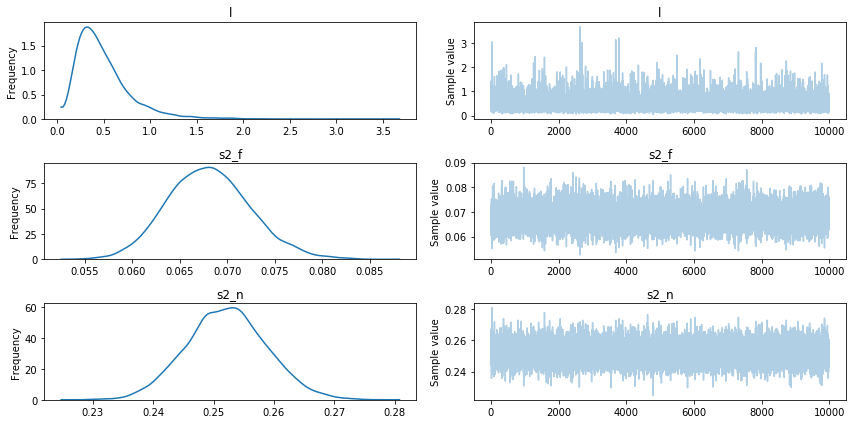

In [37]:
#temp_trace = trace[1000:]
temp_trace = trace_vi
pm.traceplot(temp_trace, varnames=['l', 's2_f', 's2_n'],
)
plt.show()

In [47]:
[[ 0,  1.5,    0.8,    0.8,   60. ,  180. ,   30. ,   75. ,   22. ]]*2

[[0, 1.5, 0.8, 0.8, 60.0, 180.0, 30.0, 75.0, 22.0],
 [0, 1.5, 0.8, 0.8, 60.0, 180.0, 30.0, 75.0, 22.0]]

In [54]:
Zn = 1000
Z = np.array([[ 0,  1.5,    0.8,    0.8,   60. ,  180. ,   30. ,   75. ,   22. ]]*Zn)
Z[:,0] = np.linspace(0, 1, Zn)

nsample = 100
with modelmini:
    gp_samples = pm.gp.sample_gp(temp_trace, y_obs, Z, samples=nsample, progressbar=None)



AttributeError: 'MvNormal' object has no attribute 'K'